In [1]:
import os
os.chdir('D:/test/')

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from BSAPR_model_1 import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(3141592)
np.random.seed(3141952)

We present a demonstration of the inference and prediction pipeline of BSAPR in this notebook. We start from the BSAPR Gaussian model. A dataset generated by randomly selecting 40% of the cells from the original of LUHMES neural progenitor cell CROP-seq data is used in this example. The data-preprocessing process of LUHMES dataset is described in [Zhou et al 2023](https://www.nature.com/articles/s41592-023-02017-4). An R implementation of the data-prerpocessing process can be found [here](https://github.com/xinhe-lab/GSFA_paper). For simplcity, we skip the data-preprocessing and directly load the pre-processed data.

# Gaussian BSAPR

In [3]:
# load the dataset
my_conditioner = my_conditioner = pd.read_csv('D:/test/LUHMES_data/LUHMES_perturbation_mat_exp.csv', index_col=0)
my_conditioner = my_conditioner.drop('Nontargeting', axis=1)  # treat the negative controls as baseline
cond_name = list(my_conditioner.columns)
my_conditioner = torch.tensor(my_conditioner.to_numpy() * 1.0, dtype=torch.float)

my_observation = pd.read_csv('D:/test/LUHMES_data/LUHMES_obs_exp.csv', index_col=0)  # the transformed responses
print(my_observation.shape)
gene_name = list(my_observation.columns)
my_observation = torch.tensor(my_observation.to_numpy() * 1.0, dtype=torch.float)

gene_name_lookup = pd.read_csv('D:/test/LUHMES_data/LUHMES_unfiltered_gene_lookup.csv')  # loading the genenames
gene_name_lookup = {gene_name_lookup.iloc[i].unfiltered_genes: gene_name_lookup.iloc[i].feature_name_lookup_unfiltered for i in range(gene_name_lookup.shape[0])}
gene_name = [gene_name_lookup[i] for i in gene_name]

my_cell_info = pd.read_csv('D:/test/LUHMES_data/LUHMES_cell_information_exp.csv', index_col=0)  # loading the cell information
my_cell_info = my_cell_info[['lib_size', 'batch', 'umi_count', 'percent_mt']]
my_cell_info.batch = pd.factorize(my_cell_info.batch)[0]
my_cell_info.umi_count = my_cell_info.umi_count/my_cell_info.lib_size
my_cell_info.lib_size = np.log(my_cell_info.lib_size)  # log transformation for numerical stability
cell_info_names = list(my_cell_info.columns)
my_cell_info = torch.tensor(my_cell_info.to_numpy() * 1.0, dtype=torch.float)

(3483, 6000)


After having loaded the cell information matrix $\mathbf{K}$, perturbation information $\mathbf{C}$ and the pre-processed responses $\mathbf{X}$, we put them into the BSAPR training pipeline.

In [ ]:
# set size of NNs
start = time.time()
output_dim = my_observation.shape[1]
sample_size = my_observation.shape[0]
hidden_node = 1000
hidden_layer_1 = 4
hidden_layer_2 = 4
conditioner_dim = my_conditioner.shape[1]
cell_info_dim = my_cell_info.shape[1]
# set Gumble softmax hyperparameters
tau = torch.tensor(1.).to(device)
# creat the BSAPR model
parametric_model = BSAPR_Gaussian(conditioner_dim=conditioner_dim, output_dim=output_dim, base_dim=cell_info_dim,
                                  data_size=sample_size, hidden_node=hidden_node, hidden_layer_1=hidden_layer_1,
                                  hidden_layer_2=hidden_layer_2, tau=tau)
parametric_model = parametric_model.to(device)

parametric_model.BSAPR_train(epoch=300, observation=my_observation, cell_info=my_cell_info, perturbation=my_conditioner, 
                             nu_1=1.0, nu_2=0.1, nu_3=1.0, nu_4=0.1, nu_5=1.0, nu_6=0.1, 
                             lr=1e-3, device=device)


Given cell states $\mathbf{K}_i$ and perturbation effects $\mathbf{C}_i$ from test set, predicted basal states $\hat m_p(\mathbf{K}_i)$, perturbation effects $\hat \gamma_p(\mathbf{C}_i)$ and posterior inclusion probabilities $\hat \eta_p(\mathbf{K}_i)$ with their associated variances can be obtained by the following function calls.

In [9]:
predicted_mu_mean, predicted_mu_var, predicted_gamma_mean, predicted_gamma_var, \
        logit_p, logit_p_log_var, predicted_base_mean = parametric_model(my_conditioner[parametric_model.test_id].to(device), my_cell_info[parametric_model.test_id].to(device))
estimated_base_mean = predicted_base_mean.detach().cpu().numpy()
estimated_perturbed_mean = (F.sigmoid(logit_p) * predicted_mu_mean).detach().cpu().numpy()
estimated_inclusion_prob = F.sigmoid(logit_p).detach().cpu().numpy()
estimated_perturbed_mean = (estimated_perturbed_mean + estimated_base_mean)
estimated_perturbed_var = logexpp1(parametric_model.base_log_var + (
            1.0 * (F.sigmoid(logit_p) > 0.5)) * predicted_gamma_mean).detach().cpu().numpy()

Visualising predicted mean responses vs observations on test set.

Text(0.5, 1.0, 'Estimated perturbed mean vs real observation on test set')

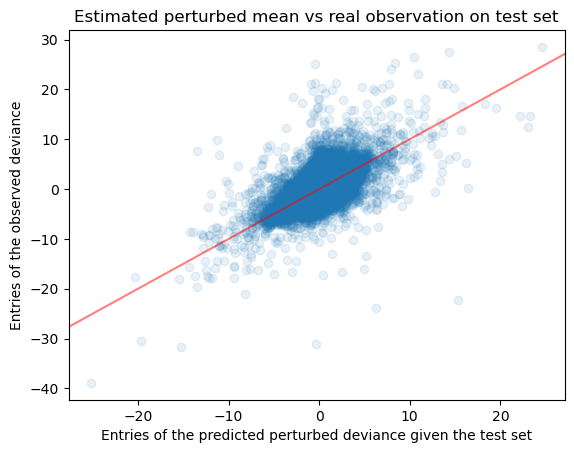

In [11]:
fig, ax = plt.subplots(1, 1)
ax.scatter(estimated_perturbed_mean.ravel(), my_observation[parametric_model.test_id].cpu().numpy().ravel(), alpha=0.1)
ax.axline((1, 1), slope=1, c='r', alpha=0.5)
ax.set_xlabel('Entries of the predicted perturbed deviance given the test set')
ax.set_ylabel('Entries of the observed deviance')
ax.set_title('Estimated perturbed mean vs real observation on test set')

The estimated "activation map" for all unique perturbations. Each cell corresponds to the estimated posterior inclusion probability of "the gene (column) is perturbed by the given perturbation (row)". A gene is included only if its posterior inclusion probability is greater than $50\%$ under at least one of the unique pertirbations. Recall that _Non Targeting_ is the baseline level. The estimated pattern reported here is slightly different to the ones reported in the paper due to subsetting.

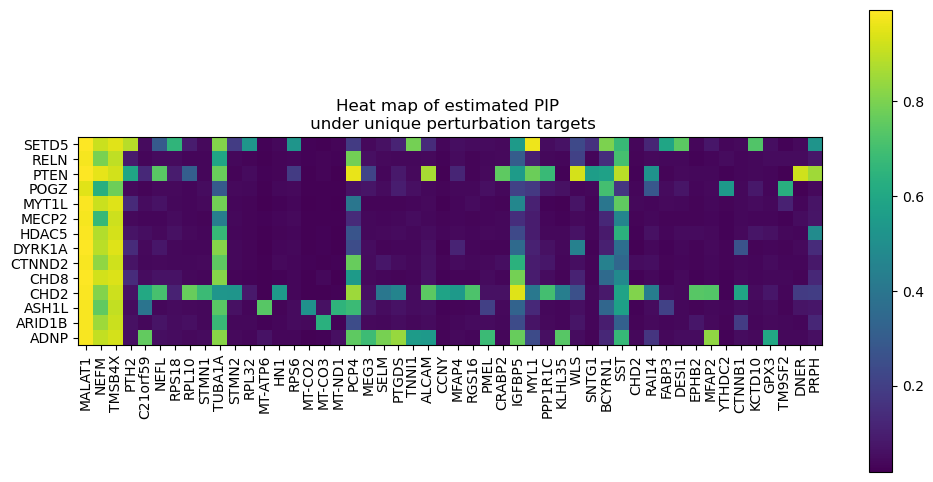

In [12]:
# how does each condition affect different genes?
threshold=0.5
top = 50
unique_conditions = torch.unique(my_conditioner, dim=0).to(device)
perturb_level, _, _, _, logit_p, _, _ = parametric_model(unique_conditions, None)
estimated_inclusion_prob = F.sigmoid(logit_p).detach().cpu().numpy()
estimated_inclusion = estimated_inclusion_prob > threshold
my_gene_name = np.array(gene_name)[estimated_inclusion.sum(axis=0) > 0]
estimated_inclusion_prob = estimated_inclusion_prob[:, estimated_inclusion.mean(axis=0) > 0]
estimated_pert = perturb_level.detach().cpu().numpy() * estimated_inclusion
estimated_pert = estimated_pert[:, estimated_inclusion.mean(axis=0) > 0]
unique_conditions = unique_conditions.cpu().numpy()

my_yticks = ['' for _ in range(unique_conditions.shape[0])]
for i in range(unique_conditions.shape[0]):
    if np.all(unique_conditions[i] == 0):
        my_yticks[i] = 'Non Targeting'
    else:
        my_yticks[i] = np.array(cond_name)[unique_conditions[i] == 1][0]

top_gene = np.argsort((estimated_pert**2).sum(axis=0))[::-1][:top]
estimated_pert_LUHMES = estimated_pert[1:, top_gene]
my_gene_name_LUHMES = my_gene_name[top_gene]
my_yticks_LUHMES = my_yticks[1:]
estimated_inclusion_prob_LUHMES = estimated_inclusion_prob[1:, top_gene]

fig, ax = plt.subplots(1, 1)
im = ax.imshow(estimated_inclusion_prob_LUHMES)
ax.set_xticks(np.arange(len(my_gene_name_LUHMES)), my_gene_name_LUHMES, rotation=90)
ax.set_yticks(np.arange(len(my_yticks_LUHMES)), my_yticks_LUHMES)
ax.set_title('Heat map of estimated PIP \n under unique perturbation targets')
fig.colorbar(im, ax=ax)
fig.set_size_inches(12, 6)

We now produce the heatmap of estimated perturbed effects under all unique perturbations. Similar to what we have reported in the paper, we only include the gene-perturbation pairs whose corresponding mean posterior inclusion probability is greater than $50\%$.

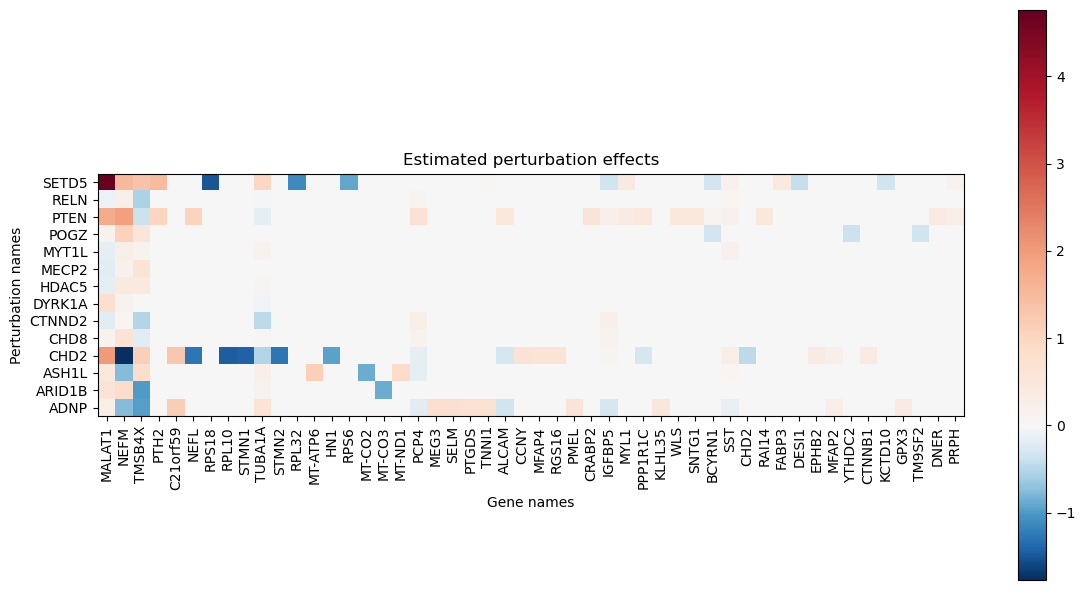

In [13]:
fig2, axes2 = plt.subplots(1, 1)
# plt.set_cmap('RdBu')

negatives = estimated_pert.min()
positives = estimated_pert.max()
num_neg_colors = int(256 / (positives - negatives) * (-negatives))
num_pos_colors = 256 - num_neg_colors
cmap_BuRd = plt.cm.RdBu_r
colors_2neg_4pos = [cmap_BuRd(0.5*c/num_neg_colors) for c in range(num_neg_colors)] +\
                   [cmap_BuRd(1-0.5*c/num_pos_colors) for c in range(num_pos_colors)][::-1]
cmap_2neg_4pos = colors.LinearSegmentedColormap.from_list('cmap_2neg_4pos', colors_2neg_4pos, N=256)

im = axes2.imshow(estimated_pert_LUHMES, cmap=cmap_2neg_4pos)
axes2.set_xticks(np.arange(len(my_gene_name_LUHMES)), my_gene_name_LUHMES, rotation=90)
axes2.set_yticks(np.arange(len(my_yticks_LUHMES)), my_yticks_LUHMES)
axes2.set_ylabel('Perturbation names')
axes2.set_xlabel('Gene names')
axes2.set_title('Estimated perturbation effects')
axes2.set_aspect('equal')
fig2.colorbar(im, ax=axes2)
fig2.set_size_inches(12, 6)
fig2.tight_layout()

# Zero-inflated Poisson BSAPR

Doing the same to the Poisson BSAPR model. First loading the datasets.

In [3]:
# load the dataset
my_conditioner = my_conditioner = pd.read_csv('D:/test/LUHMES_data/LUHMES_perturbation_mat_exp.csv', index_col=0)
my_conditioner = my_conditioner.drop('Nontargeting', axis=1)  # treat the negative controls as baseline
cond_name = list(my_conditioner.columns)
my_conditioner = torch.tensor(my_conditioner.to_numpy() * 1.0, dtype=torch.float)

my_observation = pd.read_csv('D:/test/LUHMES_data/LUHMES_obs_counts_exp.csv', index_col=0)  # the transformed responses
print(my_observation.shape)
gene_name = list(my_observation.columns)
my_observation = torch.tensor(my_observation.to_numpy() * 1.0, dtype=torch.float)

gene_name_lookup = pd.read_csv('D:/test/LUHMES_data/LUHMES_unfiltered_gene_lookup.csv')  # loading the genenames
gene_name_lookup = {gene_name_lookup.iloc[i].unfiltered_genes: gene_name_lookup.iloc[i].feature_name_lookup_unfiltered for i in range(gene_name_lookup.shape[0])}
gene_name = [gene_name_lookup[i] for i in gene_name]

my_cell_info = pd.read_csv('D:/test/LUHMES_data/LUHMES_cell_information_exp.csv', index_col=0)  # loading the cell information
my_cell_info = my_cell_info[['lib_size', 'batch', 'umi_count', 'percent_mt']]
my_cell_info.batch = pd.factorize(my_cell_info.batch)[0]
my_cell_info.umi_count = my_cell_info.umi_count/my_cell_info.lib_size
my_cell_info.lib_size = np.log(my_cell_info.lib_size)  # log transformation for numerical stability
cell_info_names = list(my_cell_info.columns)
my_cell_info = torch.tensor(my_cell_info.to_numpy() * 1.0, dtype=torch.float)

(3483, 21688)


Training the model.

In [ ]:
# design the training process:
start = time.time()
output_dim = my_observation.shape[1]
sample_size = my_observation.shape[0]
hidden_node = 1000
hidden_layer_1 = 4
hidden_layer_2 = 4
conditioner_dim = my_conditioner.shape[1]
cell_info_dim = my_cell_info.shape[1]
tau = torch.tensor(1.).to(device)

parametric_model = BSAPR_ZIP(conditioner_dim=conditioner_dim, output_dim=output_dim,
                             base_dim=cell_info_dim, data_size=sample_size,
                             hidden_node=hidden_node, hidden_layer_1=hidden_layer_1,
                             hidden_layer_2=hidden_layer_2, tau=tau)
parametric_model = parametric_model.to(device)

parametric_model.BSAPR_train(epoch=300, observation=my_observation, cell_info=my_cell_info, perturbation=my_conditioner,
                             nu_1=5.0, nu_2=0.1, nu_3=3.0, nu_4=0.1, lr=5e-4, device=device)

# torch.save(parametric_model.state_dict(), 'BSAPR_LUHMES_ZIP_exp.pt')

In [7]:
device='cpu'
parametric_model = BSAPR_ZIP(conditioner_dim=conditioner_dim, output_dim=output_dim,
                             base_dim=cell_info_dim, data_size=sample_size,
                             hidden_node=hidden_node, hidden_layer_1=hidden_layer_1,
                             hidden_layer_2=hidden_layer_2, tau=tau)
parametric_model.load_state_dict(torch.load('BSAPR_LUHMES_ZIP_exp.pt'))

<All keys matched successfully>

One can obtain estimated Poisson rates and sparse perturbation effects using similar function calls.

In [14]:
predicted_mu_mean, _, predicted_base_mean, logit_p, _ = parametric_model(my_conditioner[parametric_model.test_id].to(device), my_cell_info[parametric_model.test_id].to(device))
estimated_perturbed_mean = (F.sigmoid(logit_p) * predicted_mu_mean)
estimated_inclusion_prob = F.sigmoid(logit_p).detach().cpu().numpy()
estimated_perturbed_mean = logexpp1(estimated_perturbed_mean + predicted_base_mean).detach().cpu().numpy()

Visualising predicted mean responses vs observations on test set.

Text(0.5, 1.0, 'Estimated perturbed mean vs real observation on test set')

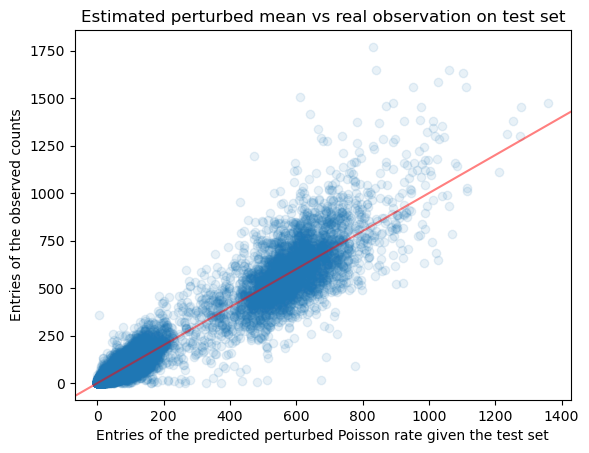

In [17]:
fig, ax = plt.subplots(1, 1)
ax.scatter(estimated_perturbed_mean.ravel(), my_observation[parametric_model.test_id].cpu().numpy().ravel(), alpha=0.1)
ax.axline((1, 1), slope=1, c='r', alpha=0.5)
ax.set_xlabel('Entries of the predicted perturbed Poisson rate given the test set')
ax.set_ylabel('Entries of the observed counts')
ax.set_title('Estimated perturbed mean vs real observation on test set')

In [19]:
threshold = 0.5
top = 50 # show at most 50 genes (cols)
unique_conditions = torch.unique(my_conditioner, dim=0).to(device)
perturb_level, _, _, logit_p, _ = parametric_model(unique_conditions, None)
estimated_inclusion_prob = F.sigmoid(logit_p).detach().cpu().numpy()
estimated_inclusion = estimated_inclusion_prob > threshold
my_gene_name = np.array(gene_name)[estimated_inclusion.sum(axis=0) > 0]
estimated_inclusion_prob = estimated_inclusion_prob[:, estimated_inclusion.mean(axis=0) > 0]
estimated_pert = perturb_level.detach().cpu().numpy() * estimated_inclusion
estimated_pert = estimated_pert[:, estimated_inclusion.mean(axis=0) > 0]

unique_conditions = unique_conditions.cpu().numpy()
my_yticks = ['' for _ in range(unique_conditions.shape[0])]
for i in range(unique_conditions.shape[0]):
    if np.all(unique_conditions[i] == 0):
        my_yticks[i] = 'Non Targeting'
    else:
        my_yticks[i] = np.array(cond_name)[unique_conditions[i] == 1][0]

top_gene = np.argsort((estimated_pert**2).sum(axis=0))[::-1][:top]
estimated_pert_LUHMES = estimated_pert[1:, top_gene]
my_gene_name_LUHMES = my_gene_name[top_gene]
my_yticks_LUHMES = my_yticks[1:]
estimated_inclusion_prob_LUHMES = estimated_inclusion_prob[1:, top_gene]

The estimated "activation map" for all unique perturbations. Each cell corresponds to the estimated posterior inclusion probability of "the gene (column) is perturbed by the given perturbation (row)". A gene is included only if its posterior inclusion probability is greater than $90\%$ under at least one of the unique pertirbations. Recall that _Non Targeting_ is the baseline level. The estimated pattern reported here is slightly different to the ones reported in the paper due to subsetting.

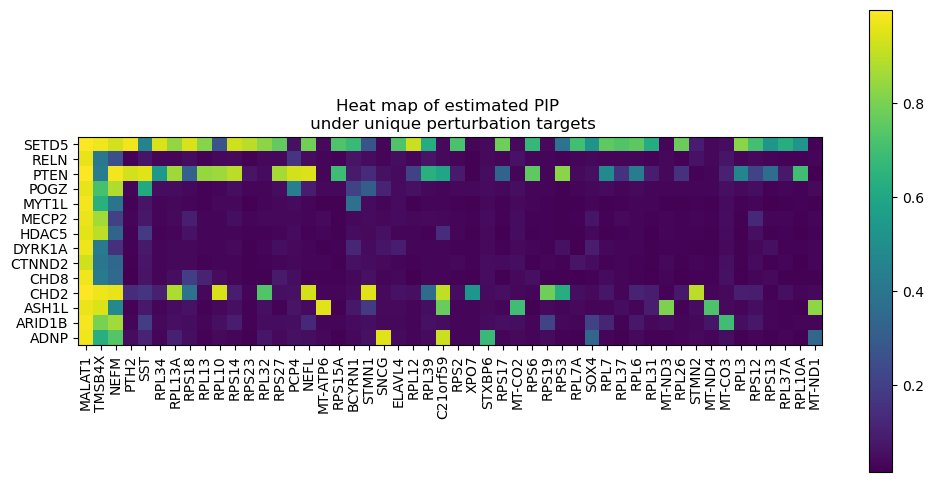

In [20]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(estimated_inclusion_prob_LUHMES)
ax.set_xticks(np.arange(len(my_gene_name_LUHMES)), my_gene_name_LUHMES, rotation=90)
ax.set_yticks(np.arange(len(my_yticks_LUHMES)), my_yticks_LUHMES)
ax.set_title('Heat map of estimated PIP \n under unique perturbation targets')
fig.colorbar(im, ax=ax)
fig.set_size_inches(12, 6)

We now produce the heatmap of estimated perturbed effects under all unique perturbations. Similar to what we have reported in the paper, we only include the gene-perturbation pairs whose corresponding mean posterior inclusion probability is greater than $50\%$.

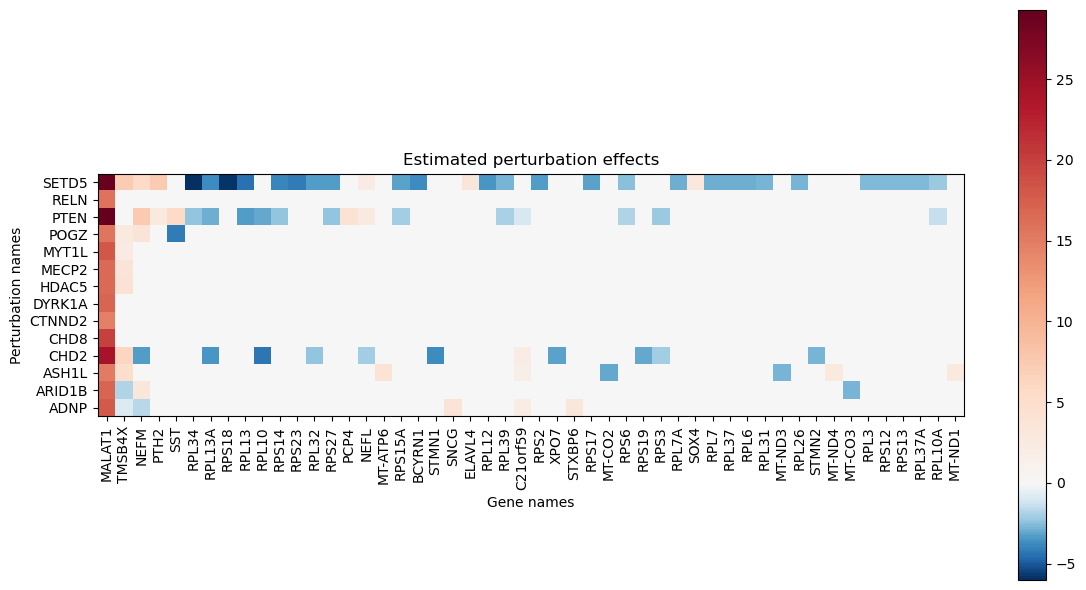

In [21]:
fig2, axes2 = plt.subplots(1, 1)
negatives = estimated_pert.min()
positives = estimated_pert.max()
num_neg_colors = int(256 / (positives - negatives) * (-negatives))
num_pos_colors = 256 - num_neg_colors
cmap_BuRd = plt.cm.RdBu_r
colors_2neg_4pos = [cmap_BuRd(0.5*c/num_neg_colors) for c in range(num_neg_colors)] +\
                   [cmap_BuRd(1-0.5*c/num_pos_colors) for c in range(num_pos_colors)][::-1]
cmap_2neg_4pos = colors.LinearSegmentedColormap.from_list('cmap_2neg_4pos', colors_2neg_4pos, N=256)

im = axes2.imshow(estimated_pert_LUHMES, cmap=cmap_2neg_4pos)
axes2.set_xticks(np.arange(len(my_gene_name_LUHMES)), my_gene_name_LUHMES, rotation=90)
axes2.set_yticks(np.arange(len(my_yticks_LUHMES)), my_yticks_LUHMES)
axes2.set_ylabel('Perturbation names')
axes2.set_xlabel('Gene names')
axes2.set_title('Estimated perturbation effects')
axes2.set_aspect('equal')
fig2.colorbar(im, ax=axes2)
fig2.set_size_inches(12, 6)
fig2.tight_layout()